<a href="https://colab.research.google.com/github/orbenishay/Classification/blob/master/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic comments classification**
![](https://techcrunch.com/wp-content/uploads/2013/06/hatespeech-tilt.jpg?w=200&crop=1)

Terms:
* NLP: **N**atural **L**anguage **P**rocessing 
* tokens: terms or words,
* tokenize = splitting a comment into the component words
* corpus: a collection of documents/sentence
* NLTK: **N**atural **L**anguage **T**ool**k**it

Assumptions:
* Which word embedding methodology to use? BOW (Bag Of Word),Word2Vec,Doc2Vec,  FastText,TFIDF 
* Word2Vec: use a trained model instead of training on this limied dataset.
* Strategy\plan how to clean the vocabulary
* Derive direct feaures from the text
* Classification of 6 categories

Pre-processing:
* Convert comments strings to lowercase
* decide if to replace \n by space or period
* remove words that have numbers inside them
* remove any other non letter charachter

Text clean:
* Multiple spaces
* Usernames
* email addresses
* '=', '-',
* IP addresses
* DateTime
* Comments that are less than 4 charachters
* Names (words that start with capital at middle of sentence)




In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import scipy
from scipy import stats
import re
import sys
import tensorflow as tf
from sklearn.manifold import TSNE # t-distributed Stochastic Neighbor Embedding; to visualize high-dimensional data. 
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features.
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
from wordcloud import WordCloud, STOPWORDS
! pip install nltk
import nltk #natural language tool kit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
!pip install replacer #replace with regex

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For the dimensionality reduction
from sklearn.feature_selection import SelectKBest , f_classif

# For the tree models
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split, GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving train1000.csv to train1000.csv


Get the data

In [0]:
traincomments=pd.read_csv('train1000.csv')
# traincomments.head()
traincomments.info()
# traincomments.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             999 non-null    object
 1   comment_text   999 non-null    object
 2   toxic          999 non-null    int64 
 3   severe_toxic   999 non-null    int64 
 4   obscene        999 non-null    int64 
 5   threat         999 non-null    int64 
 6   insult         999 non-null    int64 
 7   identity_hate  999 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 62.6+ KB


Add columns

In [0]:
traincomments['number_categories']= traincomments.iloc[:, 2:8].sum(axis=1) # categories count
traincomments['any_category']= traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].max(axis=1)
traincomments['exclamation_mark_count']=traincomments['comment_text'].str.count('!') # count '!'
def find_exclamation_mark_consecutive(x):
    n = 0
    matches = re.findall(r'[!]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n
traincomments['exclamation_mark_consecutive']=traincomments['comment_text'].apply(lambda x: find_exclamation_mark_consecutive(str(x)))
traincomments['question_mark_count']=traincomments['comment_text'].str.count('\?') # count '?'
def find_question_mark_consecutive(x): 
    n = 0
    matches = re.findall(r'[?]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n 
traincomments['question_mark_consecutive']=traincomments['comment_text'].apply(lambda x:find_question_mark_consecutive(str(x))) 
traincomments['comment_characters']=traincomments['comment_text'].str.len() #count characters
traincomments['comment_words']=traincomments['comment_text'].str.split().str.len() # count words
traincomments['comment_short']=traincomments['comment_text'].apply(lambda x: len(str(x))<=100) # number of characters less than 100
#Sentense count in each comment:
    #use '\n' to count the number of sentences in each comment #?,!,.; (list)
# traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(re.findall("\n",str(x)))+1)
traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(nltk.tokenize.sent_tokenize(str(x))))
traincomments['count_unique_word']=traincomments.comment_text.apply(lambda x: len(set(str(x).split()))) # count unique words
#count upper case words:
traincomments["count_words_upper"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#count title case words:
traincomments["count_words_title"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords:
eng_stopwords = set(stopwords.words("english"))
traincomments["count_stopwords"] =traincomments.comment_text.apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words:
traincomments["mean_word_len"] = traincomments.comment_text.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#if there is any word with all upper:
# traincomments['all_upper']=traincomments['comment_text'].str.split().apply(lambda x: np.any([True if w.isupper() else False for w in x]))
traincomments['begins_greeting'] = traincomments['comment_text'].apply(lambda x: True if re.match('^hey|hi|hello', str(x), re.IGNORECASE) else False)
traincomments['begins_I'] = traincomments['comment_text'].apply(lambda x: True if re.match('^I ', str(x), re.IGNORECASE) else False)
traincomments['begins_You'] = traincomments['comment_text'].apply(lambda x: True if re.match('^You', str(x), re.IGNORECASE) else False)
traincomments['begins_capital'] = traincomments['comment_text'].apply(lambda x: True if re.match('^[A-Z].*', str(x)) else False)
traincomments['contains_parenthesis'] = traincomments['comment_text'].apply(lambda x: True if re.search('\(|\)', str(x)) else False)
traincomments['contains_curse'] = traincomments['comment_text'].apply(lambda x: True if re.search('fuck|shit |ass| looser | dick|bitch|suck|Nazi|stupid|bullshit| piss | cock|jew| die | cunt| rape | gay | nigger | pussy|wank|faggot|dumb| crap | slut ', str(x),re.IGNORECASE) else False)
traincomments['contains_curse_replacement'] = traincomments['comment_text'].apply(lambda x: True if re.search('A$$HOLE|NIGGA|FVCK|cra*p|fxxk|b*tch', str(x),re.IGNORECASE) else False)
traincomments['contains_negative_terms'] = traincomments['comment_text'].apply(lambda x: True if re.search(' bad | terrible | kill | block | stop | wrong | destroy | absurd | don\'t | mom | mother | fat | cut | burn | ugly | kick | liar ', str(x),re.IGNORECASE) else False)
traincomments['contains_polite_words'] = traincomments['comment_text'].apply(lambda x: True if re.search('thanks|thank you|sorry|welcome', str(x),re.IGNORECASE) else False)
traincomments['contains_abbreviations'] = traincomments['comment_text'].apply(lambda x: True if re.search(' OMG | LMAO |WTF|FFS', str(x),re.IGNORECASE) else False)
def isEnglish(s): # look for sentences that have non English charachters such as významu, 通, ފުރަތަމަ
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
traincomments['contains_nonenglish'] = traincomments['comment_text'].apply(lambda x: isEnglish(x))

# **Data Exploration:**

In [0]:
# traincomments.shape
traincomments.nunique()
# traincomments.info()
# traincomments.describe()
# print(traincomments.obscene.value_counts())
# print(traincomments.threat.value_counts())
# print(traincomments.insult.value_counts())
# print(traincomments.identity_hate.value_counts())
# print(traincomments.toxic.value_counts())
# print(traincomments.severe_toxic.value_counts())

id                              999
comment_text                    999
toxic                             2
severe_toxic                      2
obscene                           2
threat                            2
insult                            2
identity_hate                     2
number_categories                 6
any_category                      2
exclamation_mark_count           12
exclamation_mark_consecutive      6
question_mark_count              10
question_mark_consecutive         5
comment_characters              559
comment_words                   219
comment_short                     2
count_sentences                  34
count_unique_word               170
count_words_upper                36
count_words_title                62
count_stopwords                 142
mean_word_len                   753
begins_greeting                   2
begins_I                          2
begins_You                        2
begins_capital                    2
contains_parenthesis        

The data does not contain missing values

# **Preliminary EDA**

,count,label
threat,4,threat
severe_toxic,9,severe_toxic
identity_hate,9,identity_hate
obscene,49,obscene
insult,54,insult
toxic,105,toxic
none,891,none


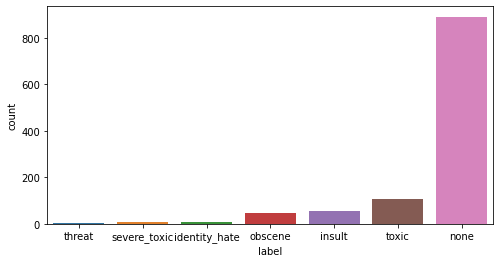

In [0]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
traincomments['none'] = (traincomments['any_category']== 0).astype(int)
COLUMNS.append('none')
df_distribution = traincomments[COLUMNS].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
df_distribution['label']=df_distribution.index
fig = plt.figure()
fig.set_size_inches(8,4)
sns.barplot(x='label', y='count', hue=None, data=df_distribution, order=None, hue_order=None);
df_distribution


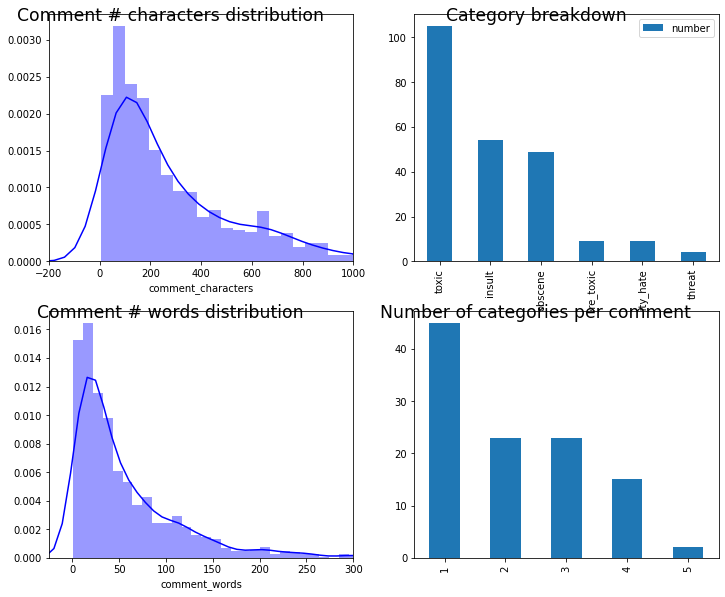

In [0]:
sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])
fig = plt.figure()
fig.set_size_inches(12,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("Comment # characters distribution", x=0.43, y=0.93, ha='center', fontsize='x-large');
ax2.set_title("Category breakdown", x=0.4, y=0.93, ha='center', fontsize='x-large');
ax3.set_title("Comment # words distribution", x=0.42, y=0.93, ha='center', fontsize='x-large');
ax4.set_title("Number of categories per comment", x=0.43, y=0.93, ha='center', fontsize='x-large');
sns.distplot(traincomments.comment_characters, bins=100, kde=True, color='blue', ax=ax1);
ax1.set_xlim(-200,2500)
sums_df.sort_values(by='number',ascending=False).plot.bar(ax=ax2);
sns.distplot(traincomments.comment_words, bins=100, kde=True, color='blue', ax=ax3);
ax3.set_xlim(-25,400)
traincomments[traincomments['number_categories']>0]['number_categories'].value_counts().sort_index(ascending=True).plot.bar(ax=ax4);
plt.show()


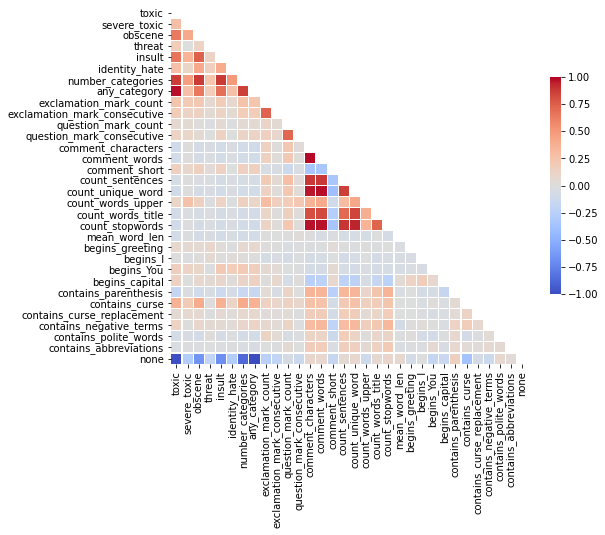

In [0]:
# corr_df = traincomments[traincomments['number_categories']>0]
corr_df = traincomments
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=False, mask=mask, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot_kws={"size": 7},cmap='coolwarm'); #

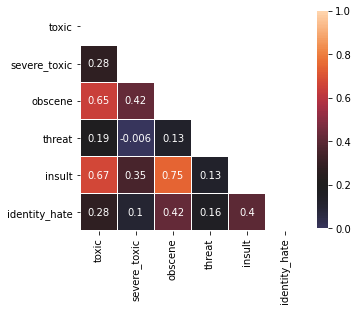

In [0]:
corr_df =traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, mask=mask, vmax=1,vmin=0, center=0.2,
            square=True, linewidths=.2, cbar_kws={"shrink": .8}, annot_kws={"size": 10});

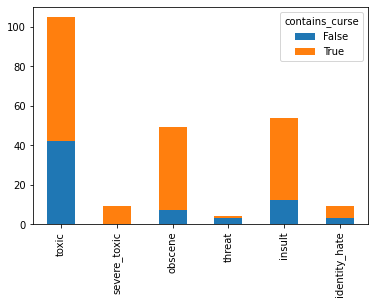

In [0]:
sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])
fig = plt.figure()
fig.set_size_inches(12,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("Comment # characters distribution", x=0.43, y=0.93, ha='center', fontsize='x-large');
ax2.set_title("Category breakdown", x=0.4, y=0.93, ha='center', fontsize='x-large');
ax3.set_title("Comment # words distribution", x=0.42, y=0.93, ha='center', fontsize='x-large');
ax4.set_title("Number of categories per comment", x=0.43, y=0.93, ha='center', fontsize='x-large');
sns.distplot(traincomments.comment_characters, bins=100, kde=True, color='blue', ax=ax1);
ax1.set_xlim(-200,2500)
sums_df.sort_values(by='number',ascending=False).plot.bar(ax=ax2);
sns.distplot(traincomments.comment_words, bins=100, kde=True, color='blue', ax=ax3);
ax3.set_xlim(-25,400)
traincomments[traincomments['number_categories']>0]['number_categories'].value_counts().sort_index(ascending=True).plot.bar(ax=ax4);
plt.show()

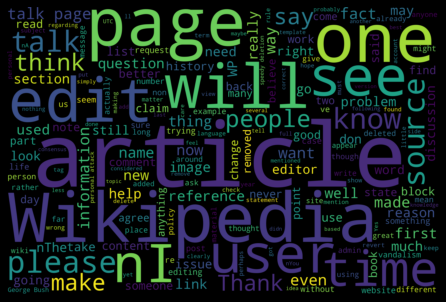

In [0]:
text = traincomments['comment_text'].values

wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (6, 6), facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Initial Cleanning & Tokenizing**

In [0]:
words_with_numbers_pattern = re.compile(r'\w*[\d]+\w*') # letter\s (0 or more), digit (1 or more), letter\s (0 or more)
special_chars_pattern = re.compile(r'[,."!?:;=&*\\/()\'$^#]+')
def clean(s):
    s = re.sub(words_with_numbers_pattern, '', s).strip()  # get rid of numbers or words with numbers 
    s = re.sub(special_chars_pattern, '', s)  # remove special chars without removing words
    # ''.join([char.strip(',."!?:;=&*\\/()\'$^#') for char in s])  # remove these characters - this is so slow-- change to re
    return s

In [0]:
traincomments_filtered  = traincomments[(traincomments['comment_words']<300)&(traincomments['comment_characters']<2000)&(traincomments['contains_nonenglish']==False)]
comment_list = traincomments_filtered['comment_text'].values # gives a list of all comments (each is a string)
comment_list_lower=list(map(lambda x:x.lower(),comment_list))
# sentences_list = [re.split('[.\n!?]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
comment_list_lower_splitline = [re.split('[\n]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
splitline_flatten = [s for sentence in comment_list_lower_splitline for s in sentence] # gives a list of all sentences (i.e. the comments that we split only by \n)
sentences_list = list(map(lambda x:nltk.sent_tokenize(x),splitline_flatten))
sentences_flat = [s for sentence in sentences_list for s in sentence] # gives a list of all sentences; we loose the comment context
sentences_clean = [clean(s) for s in sentences_flat if len(s) > 1]
words_within_sentences = [s.split() for s in sentences_clean] # list of list; words within sentences
sentences = [words_list for words_list in words_within_sentences if len(words_list)>1] # remove lists with 1 word or less

#remove non-english words
nltk.download('words')
words = set(nltk.corpus.words.words())
#" ".join(w for w in nltk.wordpunct_tokenize(traincomments['comment_text']) \
#         if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## **Word2Vec**

In [0]:
sentences_word2vec = sentences.copy()
word2vec_data = traincomments.copy()
word2vec_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,02b8c8ba3b2a1b35,I've removed it. It contributes NOTHING to the...,0,0,0,0,0,0,0,0,0,0,0,0,55,9,True,2,9,1,1,3,5.222222,False,False,False,True,False,False,False,False,False,False,1
995,02b8e9f1f138d728,""" Hi, Writingrights, Welcome to Wikipedia! \n...",0,0,0,0,0,0,0,0,4,0,0,0,1912,355,False,19,197,6,44,162,4.354930,False,False,False,False,True,False,False,True,True,False,1
996,02b90e56ec25a4c1,It is common knowledge that Karaims (but not K...,0,0,0,0,0,0,0,0,0,0,0,0,524,89,False,3,73,0,23,37,4.876404,False,False,False,True,True,True,False,False,False,False,1
997,02b91acc085c26f8,", 12 April 2006 (UTC)\nThen rewrite and expand...",0,0,0,0,0,0,0,0,0,0,0,0,523,97,False,7,75,4,8,46,4.391753,False,False,False,False,True,False,False,True,False,False,1


In [0]:
model = Word2Vec(sentences_word2vec, size=100, window=5, min_count=3, workers=4) # train the model
len(model.wv.vocab) #how many words in the vocabulary

2591

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


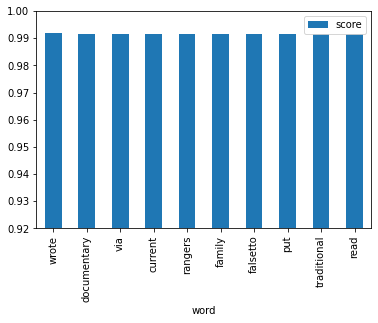

In [0]:
sims=model.wv.most_similar('kill')
sims_df=pd.DataFrame(data=sims, columns=['word','score'])
sims_df.sort_values(by='score',ascending=False).plot.bar('word','score',ylim=(0.92,1));
# def get_related_terms(token, topn=10):
#     for word, similarity in model.most_similar(positive=[token], topn=topn):
#         print (word, round(similarity, 3))

In [0]:
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()] # build a list of the terms and count
ordered_vocab_sorted = sorted(ordered_vocab, key=lambda k: -k[2]) # sort by the term counts, most common appear first
ordered_terms, term_indices, term_counts = zip(*ordered_vocab_sorted) # unzip the terms, integer indices, and counts into separate lists
word_vectors = pd.DataFrame(model.wv.syn0norm[term_indices, :], index=ordered_terms) # create a DF: vectors (data); terms (index)
word_vectors.head(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
the,-0.091992,-0.078744,-0.009681,-0.079647,-0.121265,0.021139,-0.263422,0.099181,0.027892,-0.018533,0.139766,-0.071555,0.015972,0.018465,-0.299656,0.083254,0.107105,-0.024705,0.137205,-0.030516,0.025284,0.084949,0.040596,0.144302,0.021886,-0.152731,0.000856,0.048575,0.205654,-0.119017,0.038283,-0.109466,0.081044,0.056930,0.042681,-0.012705,-0.038120,-0.146198,-0.164236,0.110744,...,0.091964,0.093885,0.047562,0.018565,-0.064172,0.194672,-0.062670,-0.032288,0.007208,-0.110658,0.026959,-0.125902,-0.022775,0.038103,-0.057165,-0.018955,-0.057907,-0.047589,-0.156731,-0.038020,-0.104378,0.089899,0.056133,0.042488,-0.146706,-0.053219,-0.043087,-0.043200,-0.109059,0.211213,-0.043468,0.005176,0.192074,0.071492,-0.024706,0.035147,0.113766,-0.043198,0.105474,0.124853
to,-0.092091,-0.078610,-0.008138,-0.081704,-0.122371,0.021931,-0.264693,0.099781,0.028029,-0.018752,0.143181,-0.070950,0.015967,0.018240,-0.299953,0.081685,0.104664,-0.025068,0.138543,-0.030609,0.024660,0.083760,0.040604,0.143637,0.022746,-0.151432,0.002384,0.048091,0.205409,-0.117635,0.039206,-0.103730,0.079794,0.055926,0.043268,-0.016150,-0.040701,-0.146120,-0.163426,0.110554,...,0.094328,0.095531,0.047263,0.019849,-0.061650,0.194457,-0.063663,-0.032312,0.008937,-0.112261,0.028457,-0.126039,-0.021488,0.039777,-0.054784,-0.020390,-0.057394,-0.047837,-0.157504,-0.039996,-0.104253,0.086004,0.052920,0.043456,-0.143760,-0.053834,-0.043409,-0.045529,-0.111304,0.214592,-0.044983,0.003639,0.192271,0.070005,-0.023855,0.038137,0.114197,-0.042868,0.105542,0.121335
of,-0.093256,-0.077414,-0.009625,-0.078830,-0.122240,0.020560,-0.264763,0.100576,0.028181,-0.020143,0.140328,-0.070659,0.016471,0.019119,-0.299924,0.081851,0.105195,-0.023288,0.137301,-0.030431,0.025664,0.084496,0.038596,0.143820,0.021980,-0.153495,0.001390,0.047097,0.205431,-0.117697,0.038941,-0.109024,0.080474,0.055541,0.040830,-0.013042,-0.039343,-0.145091,-0.161909,0.112466,...,0.095200,0.095032,0.045848,0.018850,-0.060883,0.195870,-0.064765,-0.032805,0.006728,-0.111494,0.027230,-0.127275,-0.021047,0.039574,-0.055785,-0.020665,-0.059805,-0.047608,-0.156760,-0.039297,-0.103025,0.087277,0.055151,0.043150,-0.144301,-0.053598,-0.043526,-0.043372,-0.111258,0.213542,-0.043969,0.006709,0.190781,0.070707,-0.022841,0.036694,0.112304,-0.042053,0.103707,0.124005
and,-0.091719,-0.078832,-0.009787,-0.080952,-0.120970,0.021322,-0.264149,0.099738,0.027874,-0.019805,0.141259,-0.070709,0.015183,0.018976,-0.300249,0.081431,0.106356,-0.024017,0.138035,-0.028494,0.025673,0.083606,0.039305,0.142976,0.022146,-0.152139,0.001120,0.047477,0.205578,-0.116683,0.038219,-0.107270,0.079444,0.056917,0.042761,-0.013346,-0.040340,-0.146217,-0.163304,0.112272,...,0.094614,0.095202,0.046396,0.019453,-0.061077,0.194592,-0.062775,-0.032902,0.007555,-0.112105,0.026561,-0.127552,-0.020461,0.039121,-0.055420,-0.021136,-0.057997,-0.047310,-0.156736,-0.038271,-0.104444,0.087421,0.053800,0.044000,-0.143889,-0.053321,-0.043254,-0.044448,-0.109216,0.213571,-0.045432,0.005055,0.191711,0.069996,-0.023542,0.036677,0.113248,-0.043158,0.105499,0.123517
a,-0.091811,-0.079380,-0.009420,-0.079085,-0.122764,0.023621,-0.262835,0.099594,0.029388,-0.020165,0.141629,-0.071002,0.015864,0.018260,-0.298677,0.082869,0.104732,-0.024926,0.136812,-0.029370,0.024767,0.083356,0.039215,0.143824,0.020419,-0.152316,0.001513,0.049269,0.204587,-0.117961,0.039590,-0.107398,0.080266,0.057239,0.040809,-0.013365,-0.039846,-0.146610,-0.163756,0.111154,...,0.094756,0.096495,0.048056,0.018490,-0.061916,0.193023,-0.064128,-0.032837,0.008187,-0.110585,0.028180,-0.128486,-0.022490,0.039328,-0.056453,-0.020870,-0.058692,-0.047347,-0.156731,-0.039531,-0.103725,0.088710,0.054988,0.042066,-0.146029,-0.053809,-0.042407,-0.044213,-0.108821,0.212065,-0.045770,0.006681,0.192829

## **TSNE**
t-distributed stochastic neighbor embedding

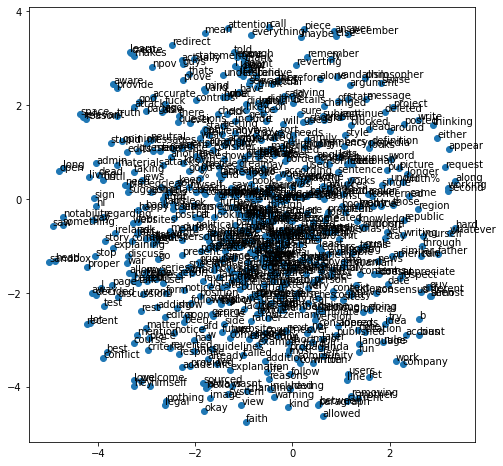

In [0]:
X = word_vectors[:700].to_numpy() # will use top most frequent
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=word_vectors[:700].index.tolist(), columns=['x', 'y'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

### **add vector per comment to training df**
need to clean comment_list before this

In [0]:
wvc=word_vectors.columns.tolist()
cols=word2vec_data.columns.tolist()
cols.extend(wvc)
word2vec_data=word2vec_data.reindex(columns=cols)
for i, comment in enumerate(comment_list):
    org_words = clean(comment).split()
    words = [w for w in org_words if w in word_vectors.index]  #remove words not in model
    comment_vector=word_vectors.loc[words].mean(axis=0)   # average the word vectors for the comment (cum then normalize for word nmber)
    word2vec_data.loc[i, wvc]=comment_vector  # add the features to the df
word2vec_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,none,0,1,2,3,4,5,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,1,-0.093516,-0.081374,-0.007477,-0.079895,-0.121299,0.021944,...,0.093109,0.094079,0.047328,0.017253,-0.064021,0.194241,-0.062840,-0.030249,0.006231,-0.109914,0.025622,-0.124323,-0.020614,0.040134,-0.052964,-0.020087,-0.055461,-0.050140,-0.155130,-0.039367,-0.103115,0.086611,0.052878,0.044309,-0.141945,-0.053197,-0.043284,-0.044432,-0.108422,0.214154,-0.044592,0.005829,0.193560,0.068431,-0.026553,0.035785,0.111728,-0.042993,0.106898,0.122927
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,1,-0.094968,-0.081502,-0.009507,-0.077738,-0.127137,0.020443,...,0.086614,0.096742,0.041602,0.021020,-0.057362,0.196849,-0.057940,-0.028657,0.011912,-0.112592,0.025096,-0.124422,-0.019599,0.036223,-0.057574,-0.019412,-0.060211,-0.051998,-0.153433,-0.038855,-0.110092,0.091152,0.044743,0.050158,-0.142234,-0.057130,-0.041853,-0.039882,-0.107704,0.214383,-0.049591,-0.001902,0.198393,0.071872,-0.030928,0.033010,0.106376,-0.047709,0.099248,0.123803
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,1,-0.092181,-0.078760,-0.009706,-0.079828,-0.122259,0.022834,...,0.094012,0.095900,0.047082,0.019530,-0.062625,0.193637,-0.063797,-0.032243,0.009044,-0.112071,0.026741,-0.127783,-0.021325,0.038539,-0.055167,-0.019319,-0.058711,-0.047084,-0.157289,-0.038457,-0.104405,0.087762,0.053141,0.042896,-0.146093,-0.052912,-0.042909,-0.044224,-0.110701,0.214090,-0.045179,0.005336,0.192584,0.070839,-0.024919,0.036406,0.113501,-0.042675,0.104586,0.122597
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,1,-0.092155,-0.078234,-0.009388,-0.080204,-0.122464,0.022703,...,0.093122,0.096908,0.047044,0.018688,-0.062593,0.193996,-0.062954,-0.032198,0.008073,-0.111444,0.026757,-0.126812,-0.021575,0.039561,-0.054695,-0.019967,-0.058020,-0.047360,-0.156999,-0.039360,-0.104464,0.087810,0.052896,0.042620,-0.144582,-0.053174,-0.042301,-0.044278,-0.110928,0.213505,-0.044661,0.004472,0.192774,0.070710,-0.024660,0.037082,0.112767,-0.042762,0.104655,0.121917
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,1,-0.095148,-0.076527,-0.010020,-0.081706,-0.119863,0.022906,...,0.093493,0.100357,0.049101,0.015166,-0.062017,0.188524,-0.059494,-0.033528,0.004165,-0.108801,0.030117,-0.120404,-0.017173,0.040683,-0.056207,-0.026104,-0.054919,-0.049956,-0.151664,-0.036907,-0.105738,0.087854,0.048617,0.038210,-0.146876,-0.051145,-0.042258,-0.049452,-0.113735,0.213129,-0.048954,0.002546,0.193626,0.072082,-0.028678,0.034140,0.110395,-0.046308,0.098440,0.121551


# **TF IDF**
“Term Frequency – Inverse Document Frequency

* **Term Frequency** : This summarizes how often a given word appears within a document.
* **Inverse Document Frequency**: This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word mortgage would be mentioned fairly often. However, if we look at other complaints, mortgage probably would not show up in many of them. We can infer that mortgage is most probably an important word in Mortgage complaints as compared to the other products. Therefore, mortgage would have a high TF-IDF score for Mortgage complaints.

process: 
1. stopword cleanning
2. stemming (go, goes, going = go)/lemmatizing (he,she,it= do)
3. clean "junk"
4. vectorizer (take the corpus and convert each doc/sentence into a sparse matrix of TFIDF)
5. LSA (dimentionality reduction)

###**Cleanning** **preprocessing**

In [0]:
#cleanning:

replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would'),
]

def strip_symbols(text):
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

class RegexpReplacer(object):
   def __init__(self, patterns=replacement_patterns):
      self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]

   def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
           s = re.sub(pattern, repl, s)
      return s

#stemmig:
from nltk.stem import WordNetLemmatizer
lemma = []
wnl = WordNetLemmatizer()
for sen in traincomments['comment_text']:
    tokens = [wnl.lemmatize(w) for w in sen]
    lemma.append(tokens)

# Removing Stopwords
filter_words = []
Stopwords = set(stopwords.words('english'))
Stopwords.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

#ab = spell('nd')
for sent in lemma:
    tokens = [w for w in sent if w not in Stopwords]
    filter_words.append(tokens)

space = ' ' 
for sentence in filter_words:
    sentences.append(space.join(sentence))


replacer=RegexpReplacer()
traincomments.comment_text = traincomments.comment_text.apply(lambda x:replacer.replace(x))
traincomments.comment_text = traincomments.comment_text.apply(lambda x:strip_symbols(x))

In [0]:
# TFIDF
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words = 'english')
 
# fit_transform
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(traincomments['comment_text'])

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
metallica,0.244098
dolls,0.244098
gas,0.244098
fac,0.244098
closure,0.244098
...,...
explain,0.000000
expires,0.000000
expired,0.000000
experts,0.000000


In [0]:
tfidf_vectorizer_vectors.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
features= tfidf_vectorizer
features.get_feature_names()

['000',
 '001',
 '002',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0cdyq6aewaq',
 '0px',
 '10',
 '100',
 '1000',
 '100000',
 '101',
 '102',
 '102cs2001',
 '103',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '1111',
 '112th',
 '117',
 '1185',
 '11th',
 '12',
 '1200',
 '12003',
 '121',
 '122',
 '123',
 '126',
 '129',
 '13',
 '130',
 '132',
 '133',
 '134',
 '136',
 '137',
 '138',
 '139',
 '1397',
 '13id',
 '13kb',
 '13th',
 '14',
 '141',
 '1439',
 '144',
 '146',
 '148',
 '149',
 '14th',
 '15',
 '150',
 '151',
 '154',
 '1547',
 '1555',
 '1558604790',
 '1562',
 '1568',
 '159',
 '16',
 '1600',
 '161',
 '162',
 '164',
 '166',
 '167',
 '168',
 '169',
 '16th',
 '17',
 '173',
 '175',
 '176',
 '177',
 '1771',
 '178',
 '17kb',
 '17th',
 '18',
 '180',
 '1800s',
 '1808',
 '181',
 '1814',
 '1816',
 '1818',
 '182',
 '183',
 '184',
 '1844',
 '185',
 '1863',
 '1869',
 '187',
 '1870',
 '1875',
 '188',
 '18th',
 '19',
 '190',
 '1900s',
 '1905',
 '191',
 '1910s',
 '1912',
 

In [0]:
print(len(features.get_feature_names()))

9075


In [0]:
tfidf_vectorizer.vocabulary_

{'explanation': 3026,
 'edits': 2743,
 'username': 8529,
 'hardcore': 3738,
 'metallica': 5154,
 'fan': 3126,
 'reverted': 6897,
 'vandalisms': 8574,
 'just': 4462,
 'closure': 1749,
 'gas': 3464,
 'voted': 8685,
 'new': 5492,
 'york': 9019,
 'dolls': 2621,
 'fac': 3076,
 'remove': 6779,
 'template': 8023,
 'talk': 7953,
 'page': 5814,
 'retired': 6880,
 '89': 335,
 '205': 183,
 '38': 260,
 '27': 233,
 'aww': 976,
 'matches': 5047,
 'background': 992,
 'colour': 1790,
 'seemingly': 7190,
 'stuck': 7754,
 'thanks': 8067,
 '21': 192,
 '51': 288,
 'january': 4377,
 '11': 27,
 '2016': 179,
 'utc': 8542,
 'hey': 3829,
 'man': 4978,
 'really': 6605,
 'trying': 8313,
 'edit': 2733,
 'war': 8718,
 'guy': 3677,
 'constantly': 1972,
 'removing': 6781,
 'relevant': 6750,
 'information': 4160,
 'talking': 7958,
 'instead': 4204,
 'care': 1484,
 'formatting': 3334,
 'actual': 451,
 'info': 4156,
 'make': 4957,
 'real': 6598,
 'suggestions': 7820,
 'improvement': 4071,
 'wondered': 8910,
 'section':

In [0]:
#LSA

#import the essential tools for lsa
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
#other imports
from os import listdir

# Fit LSA- dimensionality reduction (to 100 features) by means of truncated singular value decomposition (SVD)
lsa = TruncatedSVD(100, algorithm = 'arpack')
lsa = lsa.fit_transform(tfidf_vectorizer_vectors)
lsa

array([[ 0.13592272, -0.09836263,  0.00719988, ..., -0.02816978,
        -0.02808404,  0.03161124],
       [ 0.08009572, -0.08346836, -0.04834458, ..., -0.02357035,
        -0.0375402 ,  0.03259722],
       [ 0.22615008, -0.09234425, -0.06479027, ...,  0.05449317,
         0.02927701, -0.01303862],
       ...,
       [ 0.03823896,  0.01412725, -0.03324624, ...,  0.01350998,
        -0.00896474,  0.02266335],
       [ 0.2074877 ,  0.19386775, -0.02396977, ..., -0.00200364,
        -0.03509646,  0.00174403],
       [ 0.18984628,  0.01092158, -0.03810843, ..., -0.02092771,
        -0.00071232,  0.03977575]])

Merge the features from TFIDF with the features we created

In [0]:
data = pd.concat([traincomments, pd.DataFrame(lsa)], axis=1)
data_breakpoint = data.copy()
data_breakpoint

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,none,0,1,2,3,4,5,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,1,0.135923,-0.098363,0.007200,-0.038831,-0.024309,0.027197,...,-0.055117,-0.029299,-0.006300,0.016668,0.051696,-0.012712,0.019564,0.027815,-0.048522,-0.049478,-0.043817,-0.099242,0.022675,0.096234,0.031619,-0.038935,-0.001787,0.042152,0.063711,0.055023,-0.067714,-0.056368,-0.027847,-0.002742,-0.007125,-0.019555,-0.022014,0.011400,-0.035875,0.008376,-0.006960,-0.017595,0.041641,0.087001,-0.051017,-0.040129,-0.081162,-0.028170,-0.028084,0.031611
1,000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,1,0.080096,-0.083468,-0.048345,-0.100441,0.020473,-0.137483,...,-0.017879,0.006843,0.014255,0.011336,0.024007,0.015890,0.007892,-0.024917,0.010005,0.004405,0.009416,0.003742,0.034798,-0.037894,0.023587,0.010147,0.005586,0.026313,0.030600,-0.007162,0.023034,0.037713,-0.004240,-0.042476,-0.028790,0.043728,-0.008792,0.025724,-0.017109,-0.033676,0.026570,0.036608,-0.040479,-0.013152,-0.020067,-0.018540,0.044064,-0.023570,-0.037540,0.032597
2,000113f07ec002fd,Hey man I m really not trying to edit war It i...,0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,1,0.226150,-0.092344,-0.064790,-0.022426,0.032719,0.059549,...,0.029499,0.046507,0.006705,-0.052381,-0.006635,0.022053,0.058892,-0.026098,0.108373,-0.043474,0.009040,-0.001883,0.042398,-0.071362,0.043101,-0.031580,0.046719,0.060039,-0.078708,0.094424,0.009133,-0.003581,-0.037864,0.027958,-0.056153,0.050766,-0.126534,0.012499,0.119431,0.077118,0.036842,-0.035342,0.015268,-0.084351,0.032292,0.044203,0.057453,0.054493,0.029277,-0.013039
3,0001b41b1c6bb37e,More I cannot make any real suggestions on im...,0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,1,0.141258,0.058955,-0.044132,0.004699,-0.041663,0.000730,...,-0.002331,-0.005001,-0.072643,0.056890,0.032890,-0.022514,-0.007155,0.037103,0.082708,-0.077372,0.078672,-0.038978,0.018241,0.016812,-0.019484,-0.001581,-0.033057,0.023496,0.007343,-0.040692,0.007286,-0.042355,-0.051582,-0.032553,0.044326,0.020082,0.046569,0.053112,0.055774,0.073966,0.030567,0.022071,-0.027413,-0.011487,-0.025921,-0.009445,-0.076676,-0.042926,-0.011075,-0.014983
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,1,0.076572,-0.064909,0.045101,-0.036766,-0.017642,0.058619,...,0.034934,-0.007702,0.029061,0.021945,-0.016425,0.010007,-0.014940,0.021376,-0.052635,0.031431,0.032719,-0.003560,-0.019015,-0.025648,0.008107,0.034479,0.006074,-0.014877,-0.006258,-0.040882,-0.019664,0.020102,0.018168,-0.049435,0.061099,-0.036895,-0.007057,-0.024526,-0.066914,-0.022002,0.069408,0.031335,0.015208,-0.020040,0.006694,0.038294,0.001503,-0.034880,0.004196,0.037848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Prepare the data

In [0]:
X = data_breakpoint.drop('comment_text', axis=1)
y = data_breakpoint.comment_text

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.75, 
                                                    test_size=0.25,
                                                    shuffle=True, 
                                                    )

#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    train_size=0.75, 
#                                                    test_size=0.25,
#                                                    shuffle=True, 
#                                                    stratify=traincomments.comment_text)

Feature selection

In [0]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
#select numaries features
num_X = X.select_dtypes(include=[np.number])
num_X = num_X.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'number_categories', 'any_category', 'none'])
num_X.head()

,identity_hate,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0,0,1,0,264,43,3,41,2,11,18,5.162791,0.135923,-0.098363,0.007200,-0.038831,-0.024309,0.027197,-0.058677,-0.038076,0.042289,-0.026948,-0.024272,-0.058454,-0.027305,0.013741,-0.013494,0.088474,-0.039663,-0.009405,0.089563,0.025392,-0.015010,0.032905,-0.028870,0.030049,0.057397,-0.035626,0.053699,...,-0.055117,-0.029299,-0.006300,0.016668,0.051696,-0.012712,0.019564,0.027815,-0.048522,-0.049478,-0.043817,-0.099242,0.022675,0.096234,0.031619,-0.038935,-0.001787,0.042152,0.063711,0.055023,-0.067714,-0.056368,-0.027847,-0.002742,-0.007125,-0.019555,-0.022014,0.011400,-0.035875,0.008376,-0.006960,-0.017595,0.041641,0.087001,-0.051017,-0.040129,-0.081162,-0.028170,-0.028084,0.031611
1,0,1,0,0,0,112,17,4,17,1,3,2,5.588235,0.080096,-0.083468,-0.048345,-0.100441,0.020473,-0.137483,0.053806,-0.043648,-0.052674,0.154866,-0.007489,-0.077077,-0.076183,0.064089,-0.001974,0.014640,-0.012539,-0.037559,0.023048,-0.004905,-0.064676,-0.043652,0.025558,0.004172,0.046427,-0.025914,0.028609,...,-0.017879,0.006843,0.014255,0.011336,0.024007,0.015890,0.007892,-0.024917,0.010005,0.004405,0.009416,0.003742,0.034798,-0.037894,0.023587,0.010147,0.005586,0.026313,0.030600,-0.007162,0.023034,0.037713,-0.004240,-0.042476,-0.028790,0.043728,-0.008792,0.025724,-0.017109,-0.033676,0.026570,0.036608,-0.040479,-0.013152,-0.020067,-0.018540,0.044064,-0.023570,-0.037540,0.032597
2,0,0,0,0,0,233,42,3,39,0,2,20,4.571429,0.226150,-0.092344,-0.064790,-0.022426,0.032719,0.059549,-0.099602,-0.014335,0.075274,-0.071529,-0.009716,-0.067925,0.087561,-0.054027,0.047551,0.138250,0.001862,-0.028834,0.033819,-0.037829,-0.151664,0.065012,-0.132537,0.003165,0.029018,0.020103,0.038919,...,0.029499,0.046507,0.006705,-0.052381,-0.006635,0.022053,0.058892,-0.026098,0.108373,-0.043474,0.009040,-0.001883,0.042398,-0.071362,0.043101,-0.031580,0.046719,0.060039,-0.078708,0.094424,0.009133,-0.003581,-0.037864,0.027958,-0.056153,0.050766,-0.126534,0.012499,0.119431,0.077118,0.036842,-0.035342,0.015268,-0.084351,0.032292,0.044203,0.057453,0.054493,0.029277,-0.013039
3,0,0,0,0,0,622,113,4,82,5,7,56,4.486726,0.141258,0.058955,-0.044132,0.004699,-0.041663,0.000730,0.003498,0.067575,-0.044444,-0.003862,-0.018412,0.042711,-0.015814,0.029322,0.071508,0.008247,-0.058476,-0.049018,-0.100937,-0.003601,0.047597,0.051221,0.025896,-0.024413,0.062646,0.098262,0.073966,...,-0.002331,-0.005001,-0.072643,0.056890,0.032890,-0.022514,-0.007155,0.037103,0.082708,-0.077372,0.078672,-0.038978,0.018241,0.016812,-0.019484,-0.001581,-0.033057,0.023496,0.007343,-0.040692,0.007286,-0.042355,-0.051582,-0.032553,0.044326,0.020082,0.046569,0.053112,0.055774,0.073966,0.030567,0.022071,-0.027413,-0.011487,-0.025921,-0.009445,-0.076676,-0.042926,-0.011075,-0.014983
4,0,0,0,1,0,67,13,2,13,0,2,5,4.230769,0.076572,-0.064909,0.045101,-0.036766,-0.017642,0.058619,-0.021418,0.020157,-0.017698,-0.048089,-0.034485,-0.070090,0.114755,0.080341,0.023336,-0.036013,0.054623,0.046798,0.015527,-0.045144,-0.024283,0.006037,-0.037933,-0.016034,0.015872,-0.027097,0.033806,...,0.034934,-0.007702,0.029061,0.021945,-0.016425,0.010007,-0.014940,0.021376,-0.052635,0.031431,0.032719,-0.003560,-0.019015,-0.025648,0.008107,0.034479,0.006074,-0.014877,-0.006258,-0.040882,-0.019664,0.020102,0.018168,-0.049435,0.061099,-0.036895,-0.007057,-0.024526,-0.066914,-0.022002,0.069408,0.031335,0.015208,-0.020040,0.006694,0.038294,0.001503,-0.034880,0.004196,0.037848


In [0]:
# VarianceThreshold transformer
selector = VarianceThreshold(0.1)
selector.fit(num_X)
new_columns = num_X.columns[selector.get_support()]
new_num_X = num_X[new_columns]
new_num_X.head()

,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0,0,1,0,264,43,3,41,2,11,18,5.162791
1,1,0,0,0,112,17,4,17,1,3,2,5.588235
2,0,0,0,0,233,42,3,39,0,2,20,4.571429
3,0,0,0,0,622,113,4,82,5,7,56,4.486726
4,0,0,1,0,67,13,2,13,0,2,5,4.230769


In [0]:
#select KBest transformer
new_num_X_selector = SelectKBest(score_func=f_classif, k=5)

In [0]:
X_train_num_reduced = \
    pd.DataFrame(new_num_X_selector.fit_transform(new_num_X, y_train), 
                 columns=new_num_X_selector.columns[new_num_X.get_support()].values)
X_train_num_reduced.head()

In [0]:
#select KBest on TFIDF features
X_train_tfidf = X_train.loc[:, range(0,100)]
tfidf_selector = SelectKBest(score_func=f_classif, k=6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
853,0.082549,0.007726,-0.035446,0.033595,-0.011848,0.003911,0.041418,0.015436,-0.028672,-0.026080,0.018522,-0.004693,-0.003768,-0.007136,-0.002695,-0.043552,0.040116,-0.015570,-0.027104,-0.062658,-0.016167,0.022616,0.009794,0.000441,0.001460,0.047575,0.012412,-0.013669,-0.009874,-0.067952,0.015245,0.027037,-0.043183,-0.003419,0.014346,-0.095597,-0.000181,-0.027223,-0.010052,-0.051571,...,-0.055009,-0.006672,-0.059305,0.015789,0.072817,0.088217,-0.014143,-0.020604,-0.055631,0.001637,-0.065733,0.007618,-0.020403,0.092603,0.013119,0.029651,-0.078839,0.067486,-0.019796,0.083060,0.013762,0.028618,-0.007082,0.152817,0.059477,-0.027160,0.082194,-0.083445,-0.010287,-0.046893,-0.045200,0.035677,-0.020068,-0.046000,0.003957,0.059334,0.014978,-0.047603,0.001437,-0.022610
860,0.021322,0.019871,-0.015740,0.009637,-0.004167,0.002603,-0.006045,0.013490,0.001374,0.006357,0.014781,0.003413,0.011764,-0.019720,0.002012,-0.017011,0.000239,-0.018103,-0.032375,-0.015352,-0.014675,-0.008190,0.001807,0.011741,0.022831,-0.044418,-0.037245,0.017613,0.007903,0.002722,-0.010963,0.011577,0.026104,0.001963,0.017174,0.009369,-0.004498,-0.018191,0.008931,0.011363,...,0.017358,-0.032223,0.018350,0.006028,0.033986,0.008304,-0.018928,0.003494,0.017966,0.008000,0.035884,-0.009453,-0.037762,-0.030974,0.000090,-0.030069,0.035918,0.031172,0.012519,-0.017639,0.029641,0.009691,0.029693,0.020564,0.015569,0.021745,-0.007043,-0.008348,-0.028924,0.011766,-0.034373,0.035716,-0.018337,0.016840,0.014914,-0.016105,0.057926,0.001164,0.019470,-0.021120
740,0.081059,0.043378,0.045334,0.010150,-0.043903,-0.074455,0.084941,0.009564,0.056156,0.020563,0.173114,-0.043890,0.129327,-0.040638,0.045716,0.104401,-0.082926,0.091921,0.000039,0.049303,0.045719,-0.034605,-0.005574,-0.029483,0.029379,0.004233,0.037353,0.058620,-0.043123,-0.046911,-0.004319,-0.063202,0.002079,-0.010678,-0.016205,-0.025488,0.013204,0.005329,-0.017967,-0.028071,...,-0.007903,0.036856,0.000865,-0.015129,0.024288,0.000030,-0.017104,0.072396,-0.037848,-0.007644,-0.016987,0.025720,-0.049293,-0.015547,-0.025185,-0.062364,0.013606,-0.036862,0.066309,-0.085412,-0.064282,0.024564,-0.028839,0.009915,0.073159,-0.022240,-0.020441,-0.030992,0.014842,-0.026078,0.010449,-0.002698,0.008914,0.022673,0.057573,-0.002036,-0.018016,-0.071048,0.034930,0.026213
214,0.264512,0.173332,-0.109616,0.019494,-0.020357,0.014195,-0.077114,-0.004329,-0.015283,0.030365,0.005218,0.035231,0.020489,-0.064922,0.002995,-0.064309,-0.020461,0.021133,0.003232,0.060024,0.008870,0.037626,0.082271,-0.026167,0.055253,-0.004727,-0.030622,0.040937,0.006872,0.029663,-0.091918,0.071939,-0.051218,0.011784,0.147809,-0.040627,-0.001697,-0.022140,0.116249,-0.026782,...,-0.010159,-0.007270,-0.040168,0.070432,-0.082190,0.092660,-0.011981,0.076571,-0.044923,-0.035578,-0.042166,0.012306,0.003104,0.026130,-0.013492,-0.079262,-0.007332,-0.060773,-0.011470,0.039073,-0.048702,-0.046533,0.056620,-0.049624,0.004934,-0.054487,0.012464,0.024287,-0.025203,0.018943,-0.010981,0.069848,-0.016327,-0.014841,-0.019155,0.015842,0.016357,0.036472,0.004055,0.003194
483,0.115938,0.021462,-0.013345,0.039171,-0.043189,0.036388,-0.018988,0.068091,0.060375,0.027471,-0.009084,-0.038447,-0.071767,-0.052744,0.086862,0.055930,-0.022010,-0.015413,0.036465,-0.065527,-0.044994,0.081932,-0.041848,-0.030344,-0.061195,0.073850,0.123458,-0.000135,-0.003382,-0.041525,-0.001192,-0.067953,-0.066152,-0.050922,-0.014576,-0.081574,0.091127,-0.050272,0.129328,-0.023747,...,0.035499,0.000364,-0.021893,0.055646,0.127709,0.049806,-0.050510,0.021020,0.086228,0.026883,0.010120,-0.033512,0.095143,-0.076841,-0.027656,-0.077869,-0.024527,0.031772,-0.050395,0.015357,-0.101352,0.102422,0.018386,0.012183,-0.012985,-0.056411,0.062867,-0.087898,-0.032009,0.064699,0.073689,0.017788,-0.055458

In [0]:
X_train_tfidf_reduced = \
    pd.DataFrame(tfidf_selector.fit_transform(X_train_tfidf, y_train), 
                 columns=X_train_tfidf.columns[tfidf_selector.get_support()].values)
X_train_tfidf_reduced.head()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:110: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


,94,95,96,97,98,99
0,0.003957,0.059334,0.014978,-0.047603,0.001437,-0.022610
1,0.014914,-0.016105,0.057926,0.001164,0.019470,-0.021120
2,0.057573,-0.002036,-0.018016,-0.071048,0.034930,0.026213
3,-0.019155,0.015842,0.016357,0.036472,0.004055,0.003194
4,-0.018405,0.037494,0.030410,0.040720,-0.002074,0.056100


In [0]:
X_processed = pd.concat([X_train_tfidf_reduced, pd.DataFrame(new_num_X)], axis=1)
X_processed.head()

,94,95,96,97,98,99,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0.003957,0.059334,0.014978,-0.047603,0.001437,-0.022610,0,0,1,0,264,43,3,41,2,11,18,5.162791
1,0.014914,-0.016105,0.057926,0.001164,0.019470,-0.021120,1,0,0,0,112,17,4,17,1,3,2,5.588235
2,0.057573,-0.002036,-0.018016,-0.071048,0.034930,0.026213,0,0,0,0,233,42,3,39,0,2,20,4.571429
3,-0.019155,0.015842,0.016357,0.036472,0.004055,0.003194,0,0,0,0,622,113,4,82,5,7,56,4.486726
4,-0.018405,0.037494,0.030410,0.040720,-0.002074,0.056100,0,0,1,0,67,13,2,13,0,2,5,4.230769


# OneVsRest
Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).
In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
categories = traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
# Training logistic regression model on train data
LogReg_pipeline.fit_predict((X_processed, y_train)


In [0]:
classifier = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)
classifier_pred = classifier.fit(X_processed, y_train).predict(X_processed)

In [0]:
classifier_pred.predict_proba(X_processed)

In [0]:
classifier_pred.get_params(X_processed)